In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
# Load the .npy file
# Define the folder path
folder_path = "Datacubes/Datacubes/04_06_2025"

# List all .npy files in the folder
data_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Load all data cubes into a list
data_cubes = [np.load(os.path.join(folder_path, file)) for file in data_files]

# Print the number of loaded data cubes and their shapes
print(f"Loaded {len(data_cubes)} data cubes.")
for i, cube in enumerate(data_cubes):
    # Ensure the data is 3D
    if cube.ndim != 3:
        raise ValueError("The loaded .npy file must contain a 3D array.")
    print(f"Data cube {i} shape: {cube.shape}")
    max_value = np.max(cube)
    print(f"Maximum value in the cube {i}: {max_value}")
    min_value = np.min(cube)
    print(f"Minimum value in the cube {i}: {min_value}")

Loaded 3 data cubes.
Data cube 0 shape: (224, 224, 512)
Maximum value in the cube 0: 52256
Minimum value in the cube 0: 16
Data cube 1 shape: (125, 224, 512)
Maximum value in the cube 1: 52256
Minimum value in the cube 1: 16
Data cube 2 shape: (236, 224, 512)
Maximum value in the cube 2: 53264
Minimum value in the cube 2: 16


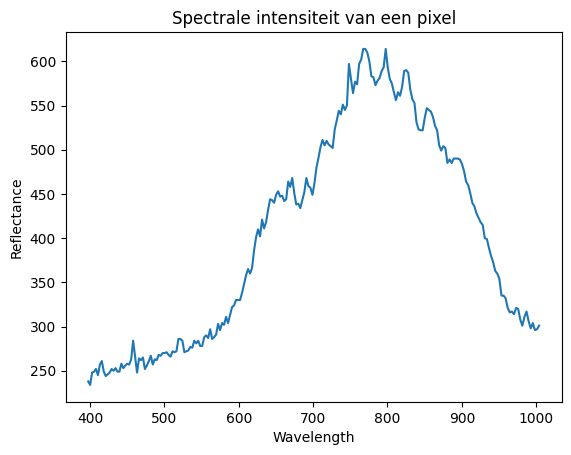

In [7]:
# Extract a single pixel's spectral data
pixel_y = 164
pixel_x = 146

pixel_data = cube[
    pixel_y:pixel_y+1,
    :,
    pixel_x:pixel_x+1
]

pixel_data_squeezed = np.squeeze(pixel_data)

# Generate a range of bands for plotting
bands = np.genfromtxt('bands.csv', delimiter=',')


plt.plot(bands, pixel_data_squeezed)
plt.title('Spectrale intensiteit van een pixel')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import spectral as spy
import matplotlib.patches as mpatches


In [155]:
# import os
# import numpy as np
# from datetime import datetime

# data_dir = "data_cubes" 

# # List all .npy files
# files = [f for f in os.listdir(data_dir) if f.endswith(".npy")]

# # Extract timestamps and sort files
# def extract_datetime(filename):
#     dt_str = filename.split('_')[2] + filename.split('_')[3].split('.')[0]  # '20250507' + '165003'
#     return datetime.strptime(dt_str, "%Y%m%d%H%M%S")

# files_sorted = sorted(files, key=extract_datetime)

# # Load the data cubes in time order
# data_cubes = [np.load(os.path.join(data_dir, f)) for f in files_sorted]
# timestamps = [extract_datetime(f) for f in files_sorted]


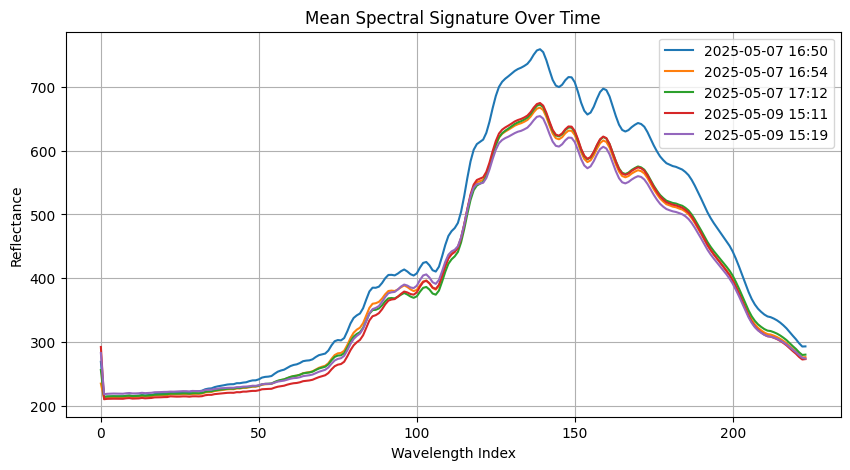

In [156]:
# import matplotlib.pyplot as plt

# # Compute mean spectrum for each cube
# mean_spectra = [np.mean(cube, axis=(0, 2)) for cube in data_cubes] 

# # Plot each spectrum
# plt.figure(figsize=(10, 5))
# for i, spectrum in enumerate(mean_spectra):
#     plt.plot(spectrum, label=timestamps[i].strftime('%Y-%m-%d %H:%M'))
# plt.legend()
# plt.title('Mean Spectral Signature Over Time')
# plt.xlabel('Wavelength Index')
# plt.ylabel('Reflectance')
# plt.grid(True)
# plt.show()


In [10]:
def generate_rgb_composite(data_cube, bands, red_range=(620, 750), green_range=(495, 570), blue_range=(450, 495)):
    """
    Generate an RGB composite image from a data cube using specified wavelength ranges.

    Parameters:
    - data_cube (numpy.ndarray): The input 3D data cube.
    - bands (numpy.ndarray): Array of band wavelengths to map to.
    - red_range (tuple): Wavelength range for the red channel (default: (620, 750)).
    - green_range (tuple): Wavelength range for the green channel (default: (495, 570)).
    - blue_range (tuple): Wavelength range for the blue channel (default: (450, 495)).

    Returns:
    - rgb_composite (numpy.ndarray): The generated RGB composite image.
    """
    # Find the indices of the bands that correspond to the wavelength ranges
    red_band = np.argmin(np.abs(bands - np.mean(red_range)))
    green_band = np.argmin(np.abs(bands - np.mean(green_range)))
    blue_band = np.argmin(np.abs(bands - np.mean(blue_range)))

    # Stack the selected bands into an RGB image
    rgb = np.stack([data_cube[:, red_band, :], data_cube[:, green_band, :], data_cube[:, blue_band, :]], axis=-1)

    # Normalize each channel separately
    rgb_norm = rgb - rgb.min(axis=(0, 1), keepdims=True)
    rgb_norm = rgb_norm / rgb_norm.max(axis=(0, 1), keepdims=True)

    # Apply gamma correction
    gamma = 1.5
    rgb_composite = np.power(rgb_norm, 1 / gamma)

    return rgb_composite


In [31]:
# Cut the everything of the datacube outside the area of interest x(189:264), y(62:102)
def crop_data_cube(data_cube, x_range=(189, 264), y_range=(62, 102)):
    """
    Crop the data cube to the specified x and y ranges.

    Parameters:
    - data_cube (numpy.ndarray): The input 3D data cube.
    - x_range (tuple): The range of x indices to keep.
    - y_range (tuple): The range of y indices to keep.

    Returns:
    - cropped_cube (numpy.ndarray): The cropped data cube.
    """
    return data_cube[y_range[0]:y_range[1], :, x_range[0]:x_range[1]]

(224,)
Red band index: 108, Wavelength: 685.5 nm


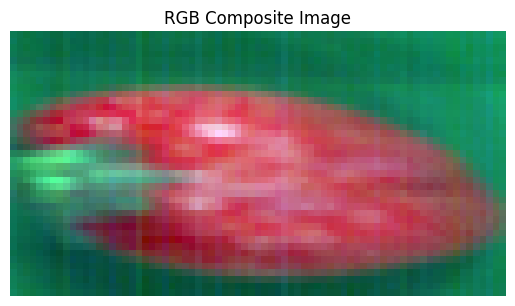

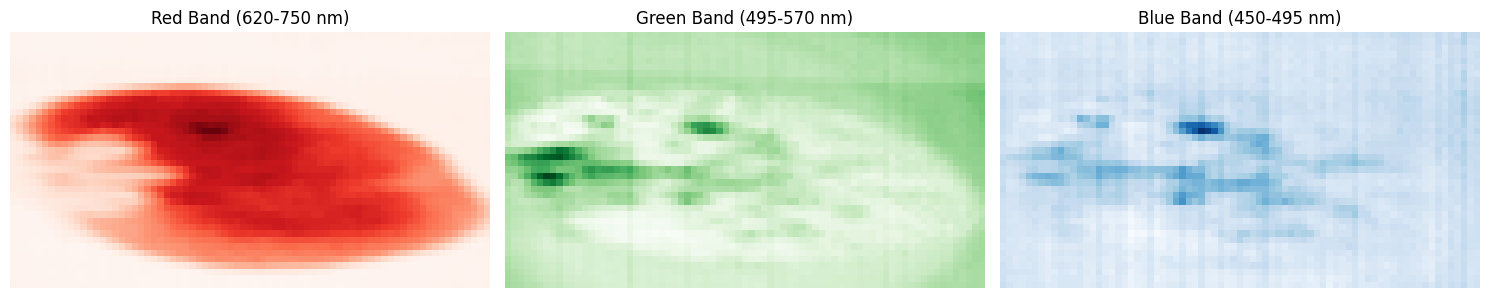

In [126]:
def process_band(data_cube, bands, band_range, crop_margin=50):
    """
    Process a specific band from the data cube by cropping, thresholding, and removing the background.

    Parameters:
    - data_cube (numpy.ndarray): The input 3D data cube.
    - bands (numpy.ndarray): Array of band wavelengths.
    - band_range (tuple): The wavelength range for the desired band (e.g., (620, 750) for red).
    - crop_margin (int): The margin to crop from the edges of the data cube.

    Returns:
    - processed_band (numpy.ndarray): The processed band with background removed.
    """
    # Crop the data cube to focus on the central region
    height, width = data_cube.shape[0], data_cube.shape[2]
    cropped_data_cube = data_cube[crop_margin:height-crop_margin, :, crop_margin:width-crop_margin]

    # Find the index of the desired band
    band_index = np.argmin(np.abs(bands - np.mean(band_range)))
    band_data = cropped_data_cube[:, band_index, :]

    # Dynamically calculate a threshold based on the data range
    threshold = band_data.mean() + band_data.std()  # Mean + 1 standard deviation
    binary_mask = band_data > threshold

    # Apply the mask to remove the background
    processed_band = np.where(binary_mask, band_data, 0)

    return processed_band

bands = np.genfromtxt('bands.csv', delimiter=',')  # Load the bands
print(bands.shape)
# Make a tuple with the wavelengts and bands of the datacube

red_range = (620, 750)  # Define the wavelength range for red
red_band_index = np.argmin(np.abs(bands - np.mean(red_range)))  # Find the index of the red band
print(f"Red band index: {red_band_index}, Wavelength: {bands[red_band_index]} nm")


# # region Datacube 00 - All Strawberries
# cube = data_cubes[0]  # Use the first data cube for processing

# cropped_cube = crop_data_cube(cube, x_range=(126,186), y_range=(93,121))

# # Generate the red data image
# red_channel_data = cropped_cube[:, red_band_index, :]
# plt.imshow(red_channel_data, cmap='Reds')
# plt.title("Red Channel Data 00")
# plt.axis("off")
# plt.show()


# # Generate the RGB composite image
# rgb_composite_00 = generate_rgb_composite(cropped_cube, bands, red_range=red_range)
# # Plot the RGB composite image
# plt.imshow(rgb_composite_00)
# plt.axis("off")
# plt.title("RGB Composite Image 00")
# plt.show()

# # Define the ROI box dimensions
# roi_height = 28
# roi_width = 60
# roi_y = red_channel_data.shape[0] // 2 - roi_height // 2 - 5
# roi_x = red_channel_data.shape[1] // 2 - roi_width // 2 - 100

# # Calculate the position of the box in the pixel coordinates of the datacube
# box_x_start = roi_x
# box_x_end = roi_x + roi_width
# box_y_start = roi_y
# box_y_end = roi_y + roi_height

# print(f"Box coordinates in pixel space: x({box_x_start}:{box_x_end}), y({box_y_start}:{box_y_end})")

# # plot the red channel data with ROI box
# plt.imshow(red_channel_data, cmap='Reds')
# plt.title("Red Channel Data with ROI Box")
# plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height,
#                                    edgecolor='blue', facecolor='none', linewidth=2))
# plt.axis("off")
# plt.show()



# endregion Datacube 00 - All Strawberries

# region Datacube 01 - Single Strawberry
cube = data_cubes[1]  # Use the first data cube for processing


# Crop the data cube and generate the RGB composite
cropped_cube = crop_data_cube(cube)
rgb_composite = generate_rgb_composite(cropped_cube, bands)
red_channel_data = cropped_cube[:, red_band_index, :]

# plot the RGB composite image
plt.imshow(rgb_composite)
plt.title("RGB Composite Image")
plt.axis("off")
plt.show()

# Generate images for specific bands
# Interesting bands to show could be Red, Green, and Blue bands for visualization
# Red band: 620-750 nm, Green band: 495-570 nm, Blue band: 450-495 nm

# Define wavelength ranges for RGB bands
green_range = (495, 570)
blue_range = (450, 495)

# Find the indices of the desired bands
green_band_index = np.argmin(np.abs(bands - np.mean(green_range)))
blue_band_index = np.argmin(np.abs(bands - np.mean(blue_range)))

# Extract data for each band
green_channel_data = cropped_cube[:, green_band_index, :]
blue_channel_data = cropped_cube[:, blue_band_index, :]

# Plot the Red, Green, and Blue band images
plt.figure(figsize=(15, 5))

# Red band
plt.subplot(1, 3, 1)
plt.imshow(red_channel_data, cmap='Reds')
plt.title("Red Band (620-750 nm)")
plt.axis("off")

# Green band
plt.subplot(1, 3, 2)
plt.imshow(green_channel_data, cmap='Greens')
plt.title("Green Band (495-570 nm)")
plt.axis("off")

# Blue band
plt.subplot(1, 3, 3)
plt.imshow(blue_channel_data, cmap='Blues')
plt.title("Blue Band (450-495 nm)")
plt.axis("off")

plt.tight_layout()
plt.show()



# endregion Datacube 01 - Single Strawberry


# region ROI in plot

# # Define the ROI box dimensions
# roi_height = 40
# roi_width = 75
# roi_y = red_channel_data.shape[0] // 2 - roi_height // 2 + 20
# roi_x = red_channel_data.shape[1] // 2 - roi_width // 2 - 30

# # Calculate the position of the box in the pixel coordinates of the datacube
# box_x_start = roi_x
# box_x_end = roi_x + roi_width
# box_y_start = roi_y
# box_y_end = roi_y + roi_height

# print(f"Box coordinates in pixel space: x({box_x_start}:{box_x_end}), y({box_y_start}:{box_y_end})")

# # Plot the red channel data with ROI box
# plt.imshow(red_channel_data, cmap='Reds')
# plt.title("Red Channel Data")
# plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, 
#                                    edgecolor='blue', facecolor='none', linewidth=2))
# plt.axis("off")
# plt.show()

# # Display the RGB composite image with ROI box
# plt.imshow(rgb_composite)
# plt.title("RGB Composite Image")
# plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, 
#                                    edgecolor='blue', facecolor='none', linewidth=2))
# plt.axis("off")
# plt.show()

# endregion

# region Save numpy
# # Show the red_band_data_no_background numpy array
# print(red_band_data_no_background)
# # Save the modified data cube
# output_filename = "red_band_data_no_background.npy"
# np.save(output_filename, red_band_data_no_background)
# endregion Save numpy

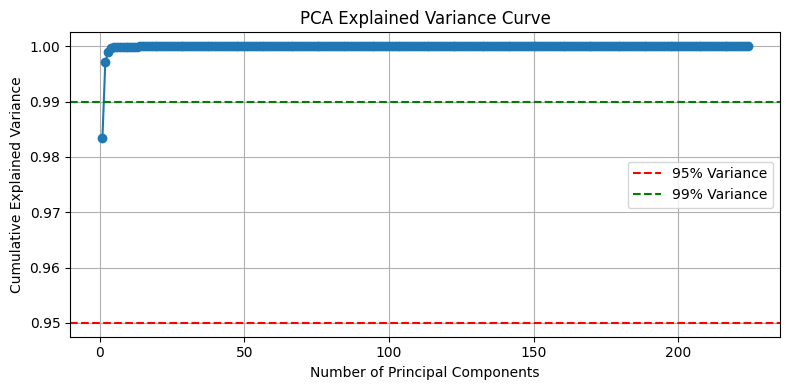

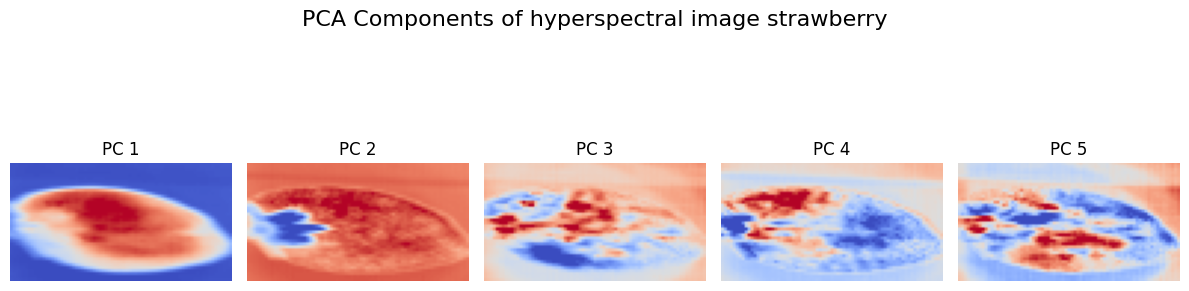

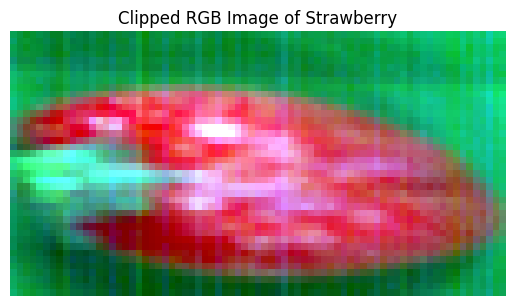

Cropped cube saved to: cropped_cube.npy


In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# === Load the Hyperspectral Data Cube ===
hsi_data = cropped_cube


# === Reshape the Cube to 2D (pixels x bands) ===
h, bands, w = hsi_data.shape
reshaped_data = hsi_data.transpose(1, 0, 2).reshape(bands, -1).T  # (height * width, bands)
reshaped_data = reshaped_data.astype(np.float64)

# === Normalize the Data ===
reshaped_data -= np.mean(reshaped_data, axis=0)

# === PCA Variance Analysis ===
pca_full = PCA()
pca_full.fit(reshaped_data)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Choose Number of Components Based on Explained Variance ===
num_components = 5

# === Apply PCA ===
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(reshaped_data)  # (pixels, components)

# === Reshape Back to Image Format (height, width, components) ===
pca_image = pca_result.T.reshape(num_components, h, w).transpose(1, 2, 0)

# == Display PCA Components with Percentile Clipping ==
plt.figure(figsize=(12, 8))
for i in range(num_components):
    pc = pca_image[:, :, i]
    
    # Apply percentile-based clipping
    percentiles = (2, 98)  
    vmin, vmax = np.percentile(pc, percentiles)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(pc, cmap='coolwarm', vmin=vmin, vmax=vmax)
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('PCA Components of hyperspectral image strawberry', fontsize=16)
plt.show()

def clip_percentile(img, lower=2, upper=98):
    vmin = np.percentile(img, lower)
    vmax = np.percentile(img, upper)
    img_clipped = np.clip((img - vmin) / (vmax - vmin), 0, 1)
    return img_clipped

# Assume rgb_composite is shape (H, W, 3)
rgb_clipped = np.zeros_like(rgb_composite)

for i in range(3):  # R, G, B channels
    rgb_clipped[:, :, i] = clip_percentile(rgb_composite[:, :, i])


# plot the rgb composite image of original data cube
plt.imshow(rgb_clipped)
plt.title("Clipped RGB Image of Strawberry")
plt.axis("off")
plt.show()


# # === Save the PCA Output if Needed ===
# output_path = "pca_output/pca_image.npy"
# os.makedirs(os.path.dirname(output_path), exist_ok=True)
# np.save(output_path, pca_image)
# print(f"PCA image saved to: {output_path}")


# Save cropped cube
output_path = "cropped_cube.npy"
os.makedirs(folder_path, exist_ok=True)
np.save(os.path.join(folder_path, output_path), cropped_cube)
print(f"Cropped cube saved to: {output_path}")


Cube shape after transpose: (40, 75, 224)
Reshaped data shape for PCA: (3000, 224)


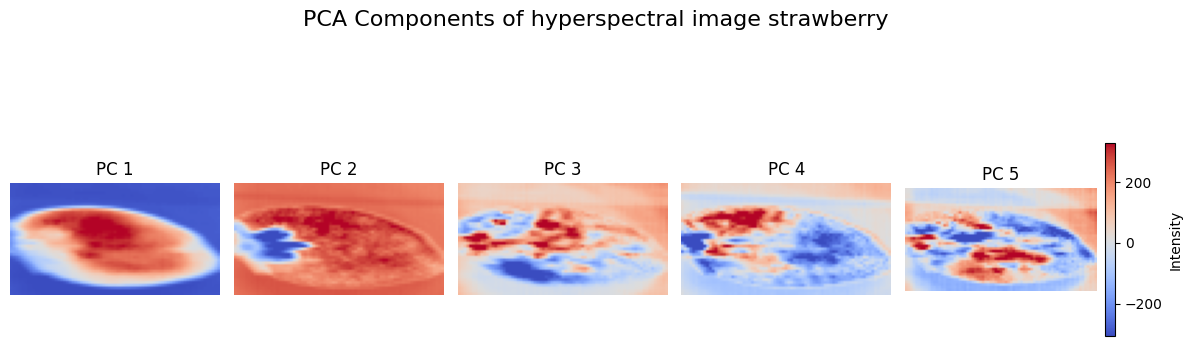

In [151]:
from sklearn.preprocessing import StandardScaler
# Original shape: (height, bands, width)
cube = np.transpose(cropped_cube, (0, 2, 1))  # Now (H, W, B)
print(f"Cube shape after transpose: {cube.shape}")

# Reshape for PCA
reshaped_data = cube.reshape(-1, cube.shape[2])  # (pixels, bands)
print(f"Reshaped data shape for PCA: {reshaped_data.shape}")

# === Reshape the Cube to 2D (pixels x bands) ===
h, bands, w = hsi_data.shape
reshaped_data = hsi_data.transpose(1, 0, 2).reshape(bands, -1).T  # (height * width, bands)
reshaped_data = reshaped_data.astype(np.float64)

# === Normalize the Data ===
reshaped_data -= np.mean(reshaped_data, axis=0)

# === PCA Variance Analysis ===
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(reshaped_data)  # (pixels, components)

# === Reshape Back to Image Format (height, width, components) ===
pca_image = pca_result.T.reshape(num_components, h, w).transpose(1, 2, 0)


# Reshape each principal component for display
pc_images = []
height, width = cube.shape[:2]
for i in range(n_components):  # Loop over the first 3 principal components
    pc_image = principal_components[:, i].reshape(height, width)
    pc_images.append(pc_image)

# == Display PCA Components with Percentile Clipping ==
plt.figure(figsize=(12, 8))
for i in range(num_components):
    pc = pca_image[:, :, i]
    
    # Apply percentile-based clipping
    percentiles = (2, 98)  
    vmin, vmax = np.percentile(pc, percentiles)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(pc, cmap='coolwarm', vmin=vmin, vmax=vmax)
    plt.title(f'PC {i + 1}')
    plt.axis('off')
# plt.tight_layout()
plt.suptitle('PCA Components of hyperspectral image strawberry', fontsize=16)
plt.colorbar(label='Intensity', ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout(pad=1.0)  # Smaller pad = tighter spacing
plt.show()


# # # === K-Means Clustering ===
# from sklearn.cluster import KMeans
# # Define the number of clusters
# num_clusters = 5  # Adjust as needed
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# # Fit the KMeans model
# kmeans.fit(principal_components)
# # Get the cluster labels
# labels = kmeans.labels_
# # Reshape labels back to the original image shape
# labels_image = labels.reshape(cube.shape[0], cube.shape[1])
# # Plot the clustered image
# plt.figure(figsize=(10, 10))
# plt.imshow(labels_image, cmap='jet', interpolation='nearest')
# # plt.title(f'K-Means Clustering (k={num_clusters})')
# plt.axis('off')
# # plt.colorbar(label='Cluster Label')
# plt.show()



